In [1]:
import numpy as np
import os
import pickle
from utilities_ketamine_analysis_v8 import *
from utils_signal_processing import *
from utils_plotting import *
from utils_general import *
from scipy.signal import morlet, welch, convolve
import matplotlib.gridspec as gridspec
import time 

#### HPC start and end indexes

In [2]:
sess = 2

# HPC start and end 
ch_start = 75*2  # theta start
ch_end = 131*2 # theta end 

# CA1 start and ending point, with the fulling labeling (all electrodes)
so_start = ch_start  # theta start, beginning of stratum oriens 
so_end = 85*2 # end of stratum oriens 
sp_start = so_end + 1 # beginning of stratum pyramidale
sp_end = 98*2    # end of stratum pyramidale

hpc_start = 75 
hpc_end = 131 

print('N of channels in S.O.', so_end - so_start)
print('N of channels in S.P.', sp_end - sp_start)

N of channels in S.O. 20
N of channels in S.P. 25


### Load behavior for all sessions

In [3]:
speed_path = r'C:\Users\fentonlab\Desktop\Gino\behaviour\\'
x = np.load(os.path.join(speed_path, "x_aln.npy"), allow_pickle=True)
y = np.load(os.path.join(speed_path, "y_aln.npy"), allow_pickle=True)
speed = np.load(os.path.join(speed_path, "speed_aln.npy"), allow_pickle=True)
yaw = np.load(os.path.join(speed_path, "yaw_aln.npy"), allow_pickle=True)

In [4]:
beh_binned_all = []

for ipath in range(0,len(x)):
    # print(ipath)
    
    behavior_con = []
    behavior_con = np.array([x[ipath],y[ipath],yaw[ipath],speed[ipath]])
    
    beh_binned_all.append(behavior_con)

### Load paths and ephys files for spiking activity

In [5]:
out_path = Path(r'C:\Users\fentonlab\Desktop\Gino\HPC_channel_info\\')

sync_PATH = os.path.join(out_path,'sync_path_matched.pkl')
nt_PATH = os.path.join(out_path,'nt_path_matched.pkl')
ksort_PATH = os.path.join(out_path,'ksort_HPC_path_matched.pkl')
ts_ephys_PATH = os.path.join(out_path,'ts_ephys_aln.pkl')

with open(sync_PATH,'rb') as file:
    sync_path_matched = pickle.load(file)
    
with open(nt_PATH,'rb') as file:
    nt_path_matched= pickle.load(file)
    
with open(ksort_PATH,'rb') as file:
    ksort_HPC_path_matched = pickle.load(file)
    
with open(ts_ephys_PATH,'rb') as file:
    ts_ephys_aln = pickle.load(file)


### Load spike files for a given session (takes about 3 min)

In [8]:
start_time = time.time()
# load HPC file names and store them in rec spikes at 250 Hz
# path_spike = Path(r'Z:\\NeuroPix\spk_ketamine\HPC\\')
path_spike = Path(r'\\sshfs.r\gino@monk.cns.nyu.edu\f\fentonlab\RAWDATA\NeuroPix\spk_ketamine\HPC\\')

rec_name = 'spk_250Hz_' + str(sess) + '.file'
spk_file_name = os.path.join(path_spike , rec_name)

with open(spk_file_name,'rb') as f:
    spikes_binned_all_HPC = pickle.load(f)
    
time_taken = time.time() - start_time
print(f"Time of execution {time_taken} in sec")

Time of execution 482.5489025115967 in sec


In [9]:
# check dimension of spikes and behaviour (at 100 Hz)
spikes_binned_all_HPC[0].shape[1], x[0].shape, speed[0].shape

(1800499, (720214,), (720214,))

In [10]:
spk = spikes_binned_all_HPC

### Load LFP for a given session -- Only CA1

#### Define paths and load

In [11]:
binFullPath = r'C:\Users\fentonlab\Desktop\Gino\LFPs'
main_dir = r'C:\Users\fentonlab\Desktop\Gino\LFPs\HPC'
HPC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','HPC_lfp_paths.file')
PFC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','PFC_lfp_paths.file')

# ====== Load Lfp and speed data for a specific recording and brain area 
rec = load_rec_path(binFullPath,HPC_path_file,PFC_path_file,"HPC",sess)
path = rec[sess]['HPC']
dir_sess = path.split('\\')[-3] # path for session directory
full_dir_path = os.path.join(main_dir,dir_sess)
out_file = os.path.join(full_dir_path, "lfp_epoch_all_trials_CSD_x_avg.mat")
lfp = loadmat(out_file)

Loading file in:  Z:\NeuroPix\Ketamine\2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk\2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk_g0_imec1\2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk_g0_t0.imec1.lf.bin


In [12]:
lfp_B = lfp['lfp_all']['B'][0][0]
lfp_L = lfp['lfp_all']['L'][0][0]
lfp_M = lfp['lfp_all']['M'][0][0]
lfp_H = lfp['lfp_all']['H'][0][0]

In [13]:
# min, length of 60 sec recording at 1250 Hz, channel
lfp_B.shape

(20, 75000, 56)

### Load low/high speed masks for a given session

In [14]:
in_file = os.path.join(full_dir_path, "mask_low_high_speed_CSD_x_avg.mat")
mask = loadmat(in_file)

In [15]:
mask_B = mask['mask']['B_low'][0][0]
mask_L = mask['mask']['L_low'][0][0]
mask_M = mask['mask']['M_low'][0][0]
mask_H = mask['mask']['H_low'][0][0]

In [16]:
# min, 60 sec of mask - one element for each second, channel
mask_B.shape

(20, 60, 56)

#### Upsample behavior at 250 Hz (input at 100 Hz)

In [593]:
def upsample_behaviour(spk, speed, x, y, sess, spk_rate = 250, behav_rate = 100):
    
    # time length for speed and spike variables
    behav_T = np.linspace(0, len(speed[sess])/ behav_rate, len(speed[sess]))
    spk_T = np.linspace(0, spk[0].shape[1]/ spk_rate, spk[0].shape[1]) # all cells have same time length

    # interpolate speed variable based on spike 
    interpolator = interp1d(behav_T, speed[sess], kind = 'linear', fill_value="extrapolate")
    speed_upsampled = interpolator(spk_T)
    
    # interpolate x variable based on spike 
    interpolator = interp1d(behav_T, x[sess], kind = 'linear', fill_value="extrapolate")
    x_upsampled = interpolator(spk_T)
    
    # interpolate y variable based on spike 
    interpolator = interp1d(behav_T, y[sess], kind = 'linear', fill_value="extrapolate")
    y_upsampled = interpolator(spk_T)
    
    # check if upsample done correctly
    if (speed_upsampled.size - spk[0].shape[1]) !=0:
        sys.exit("Speed upsampled size and spike size are not the same!")
    print('speed upsampled shape {}, spike shape {}'.format(speed_upsampled.shape, spk[0].shape))
    
    return speed_upsampled, x_upsampled, y_upsampled

In [594]:
speed_up, x_up, y_up = upsample_behaviour(spk, speed, x, y, sess)
beh_data = [None,None]
beh_data[0] = x_up
beh_data[1] = y_up

speed upsampled shape (1800499,), spike shape (223, 1800499)


#### Downsample Lfp at 250 Hz (input at 1250 Hz)

In [17]:
LfpSB = lfp_B[:,::5,:] # original Lfp is sampled at 1250 Hz 
LfpSL = lfp_L[:,::5,:] 
LfpSM = lfp_M[:,::5,:] 
LfpSH = lfp_H[:,::5,:] 
LfpSB.shape

(20, 15000, 56)

### spike-cell index for cells in HPC

In [75]:
# spike time of cell 0
spk[0][0][0:1000]
# mapping array between cell number and LFP channel
spk[2][:]

array([  2,   1,   5,   2,   8,   6,   7,   7,   6,  12,   9,  11,  10,
         7,   8,   9,   7,  10,  11,  11,  15,  13,  12,  12,  14,  17,
        20,  17,  17,  17,  21,  21,  21,  21,  23,  21,  22,  26,  28,
        27,  27,  27,  26,  26,  26,  27,  30,  28,  28,  27,  27,  37,
        34,  33,  32,  32,  37,  41,  40,  41,  39,  44,  41,  41,  48,
        47,  47,  46,  50,  50,  55,  52,  53,  52,  55,  55,  53,  52,
        53,  53,  57,  59,  61,  61,  63,  63,  67,  69,  67,  68,  67,
        69,  71,  71,  70,  73,  72,  73,  72,  73,  73,  81,  76,  77,
        82,  83,  85,  83,  84,  85,  86,  85,  87,  89,  88,  89,  85,
        84,  86,  86,  89,  89,  89,  89,  88,  95, 100,  99, 100, 105,
       100, 100, 100, 108, 113, 116, 121, 118, 127, 130, 132, 128, 128,
       132, 135, 132, 135, 132, 132, 132, 134, 136, 136, 136, 139, 136,
       138, 146, 151, 148, 148, 151, 154, 149, 150, 167, 173, 172, 175,
       180, 179, 178, 179, 188, 188, 190, 192, 193, 194, 200, 19

In [72]:
condition = (spk[2] >= hpc_start*2) & (spk[2] <= hpc_end*2) # get map of cells in CA1
idx_cell_hpc = np.where(condition)[0] # get index of cells in CA1
idx_cell_hpc

array([158, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209], dtype=int64)

In [20]:
condition = (spk[2] >= hpc_start*2) & (spk[2] <= hpc_end*2) # get map of cells in CA1
idx_cell_hpc = np.where(condition)[0] # get index of cells in CA1
print("Cell index in full labeling:  \n", idx_cell_hpc) # print cell index 
print("Lfp channel associated to cell in full labeling:  \n", spk[2][idx_cell_hpc]) # print cell LFP channel 

Cell index in full labeling:  
 [158 161 162 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209]
Lfp channel associated to cell in full labeling:  
 [151 151 154 150 167 173 172 175 180 179 178 179 188 188 190 192 193 194
 200 198 199 195 208 211 213 213 216 216 208 220 220 220 216 216 217 220
 223 216 221 212 226 230 228 228 234 234 236 258 259]


### Cell density associated to a given LFP -- how many cells for an LFP channel 

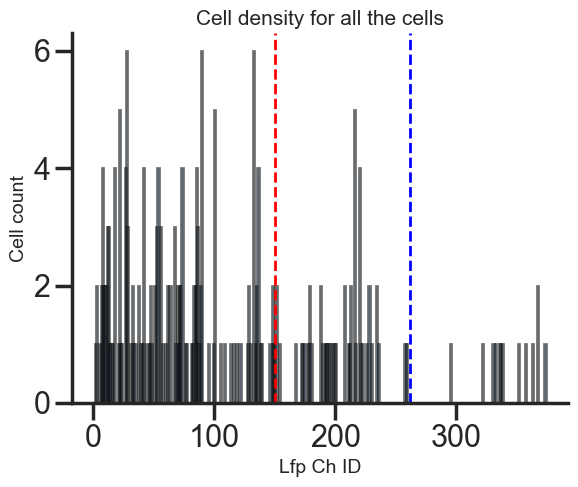

In [21]:
hist, bin_edges = np.histogram(spk[2], bins=374)
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.55)
plt.axvline(x=ch_start, color='red', linestyle='dashed', linewidth=2)
plt.axvline(x=ch_end, color='blue', linestyle='dashed', linewidth=2)

plt.xlabel('Lfp Ch ID',fontsize=14)
plt.ylabel('Cell count',fontsize=14)
plt.title('Cell density for all the cells',fontsize=15)
plt.show()

In [22]:
# Path for the session currently being analyzed
ksort_HPC_path_matched[sess]

WindowsPath('C:/Users/fentonlab/Desktop/Tony/Neurotar_HPC_ketamine/SPK/electrophysiology/2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk_HPCprobe')

### Lfp at 1250 Hz vs Lfp at 250 Hz

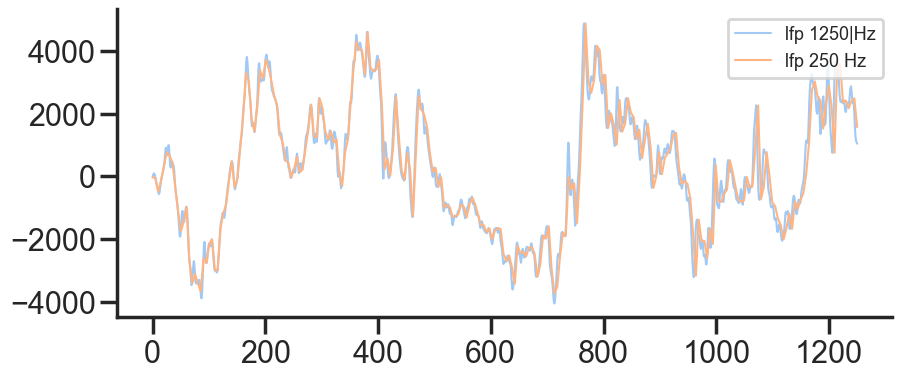

In [24]:
minute = 0
ch = 0
fs = 1250
duration = 1

t = np.linspace(0,duration*fs,duration*fs)
t_down = np.linspace(0,duration*fs,int(duration*fs/5))

plt.figure(figsize=(10,4))
plt.plot(t,lfp_B[minute,0:fs*duration,ch], linewidth=1.5)
plt.plot(t_down,LfpSB[minute,0:int(fs/5*duration),ch], linewidth=1.5)
plt.legend(['lfp 1250|Hz','lfp 250 Hz'], loc='upper right',fontsize=13)
# plt.grid(linewidth=0.5)

#### Frequencies in logscale for spike-LFP analysis

In [25]:
# frequency range values 
# freq = np.logspace(0.32, 2, num=60, endpoint=True)
# freq

freq = np.logspace(0.32, 2.48, num=70, endpoint=True)
freq

array([  2.08929613,   2.24545496,   2.41328546,   2.59366   ,
         2.78751614,   2.99586155,   3.21977917,   3.46043292,
         3.71907368,   3.99704585,   4.29579431,   4.61687191,
         4.9619476 ,   5.33281505,   5.73140198,   6.15978023,
         6.62017645,   7.11498376,   7.64677411,   8.2183117 ,
         8.83256733,   9.49273384,  10.20224273,  10.96478196,
        11.78431513,  12.66510211,  13.61172115,  14.62909268,
        15.72250491,  16.89764131,  18.16061012,  19.51797613,
        20.97679483,  22.54464901,  24.22968824,  26.04067119,
        27.98701121,  30.07882518,  32.32698617,  34.74317991,
        37.33996556,  40.13084098,  43.13031288,  46.35397226,
        49.81857539,  53.54213098,  57.54399373,  61.84496496,
        66.46740074,  71.43532805,  76.77456975,  82.51287873,
        88.68008219,  95.30823671, 102.43179484, 110.08778418,
       118.31599988, 127.15921146, 136.66338513, 146.87792273,
       157.8559185 , 169.65443508, 182.33480009, 195.96

### Extract instantaneous phase using a Morlet transform from LFP signal

#### Function to extract instantaneous phase from Morlet Wavelet

In [217]:
def instantaneous_phase_wavelet_cycles(signal, frequencies, num_cycles, sampling_freq):
    
    T, nch = signal.shape
    phase_data = np.zeros((len(frequencies), T, nch))
    conv_data = np.zeros((len(frequencies), T, nch))
    wave_list, t_wave = [], []
    
    for f_idx, frequency in enumerate(frequencies):
        # Compute the wavelet 
        sigma = num_cycles / (2 * np.pi * frequency)   # s = n/(2*pi*f) -- standard deviation of the Gaussian
        t = np.arange(-3.5*sigma, 3.5*sigma, 1/sampling_freq)    # length of the wavelet 
        wavelet = np.exp(2j * np.pi * frequency * t) * np.exp(-t**2 / (2 * sigma**2))   # Morlet Wavelet 
        
        wave_list.append(wavelet) # store wavelets for each frequency
        t_wave.append(t)
        
        for ch in range(nch):
            # Convolve signal with wavelet
            convolution = convolve(signal[:,ch], wavelet, 'same')
            # Extract instantaneous phase
            phase_data[f_idx, :, ch] = np.angle(convolution)  # instantaneous phase, for each frequency, for each channel 
            conv_data[f_idx, :, ch] = convolution.real
            
    return phase_data, wave_list, conv_data, t_wave

In [26]:
lfp_B.shape, LfpSB.shape

((20, 75000, 56), (20, 15000, 56))

### Morlet wavelet with n cycles

t size 2322


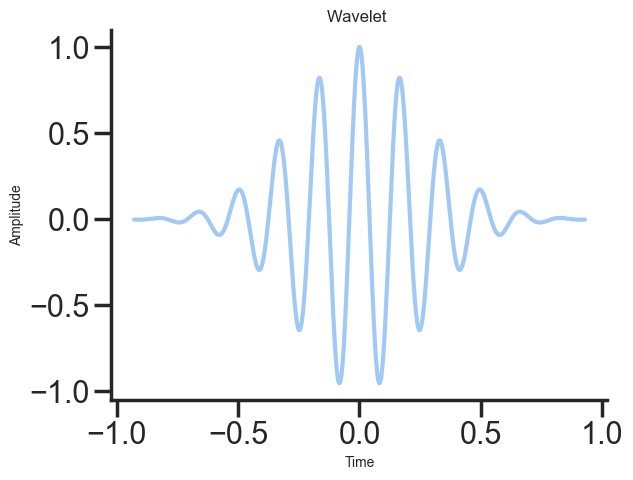

In [219]:
frequency = 6
num_cycles = 10

sigma = num_cycles / (2 * np.pi * frequency)
t = np.arange(-3.5*sigma, 3.5*sigma, 1/fs)
# t = np.arange(-duration/2, duration/2, 1/sampling_rate)
wavelet = np.exp(2j * np.pi * frequency * t) * np.exp(-t**2 / (2 * sigma**2))
print('t size', t.size)

plt.plot(t, wavelet)
plt.title('Wavelet ',fontsize=12)
plt.xlabel('Time',fontsize=10)
plt.ylabel('Amplitude',fontsize=10)
# plt.legend(fontsize=12, loc='upper right')
# plt.xlim([0,100])
plt.show()

### C. Phase estimation for each low-speed LFP period

##### Extract instantaneous phase for a LFP segment

In [27]:
""" 
Compute instantaneous phase by using Morlet wavelet with n cycles, for a range of frequencies,
at a given sampling frequency for the signal for each minute and each channel of data 

Inputs: 
segment: LFP segment data for low speed
frequencies: range of frequencies for phase extraction (1D array)
num_cycle: n parameter in the Gaussian kernel for the number of cycles
sampling_freq 
"""
def phase_wavelet_cycles_min_ch(segment, frequencies, num_cycles, sampling_freq):
    
    T = segment.size
    phase_data = np.zeros((T, len(frequencies)))
    conv_data = np.zeros((T, len(frequencies)))
    wave_list, t_wave = [], []
    
    for f_idx, frequency in enumerate(frequencies):
        
        # Compute the wavelet 
        sigma = num_cycles / (2 * np.pi * frequency)   # s = n/(2*pi*f) -- standard deviation of the Gaussian
        t = np.arange(-3.5*sigma, 3.5*sigma, 1/sampling_freq)    # length of the wavelet 
        wavelet = np.exp(2j * np.pi * frequency * t) * np.exp(-t**2 / (2 * sigma**2))   # Morlet Wavelet 
        
        # store wavelets for each frequency
        wave_list.append(wavelet) 
        t_wave.append(t)
        
        # Convolve signal with wavelet
        convolution = convolve(segment, wavelet, 'same')
        # Extract instantaneous phase
        phase_data[:, f_idx] = np.angle(convolution)  # instantaneous phase, for each frequency, for each channel 
        conv_data[:, f_idx] = convolution.real
            
    return phase_data, wave_list, conv_data, t_wave

##### Extract phase for a LFP epoch - low speed

In [28]:
"""
Compute the instantaneous phase for the LFP chunks of data which are low speed.
- mask array contains 1 for low speed and 0 for high speed data. The LFP is masked with this
array for each channel and minute of the data, to get LFP low speed only.

LFP Low speed segments are identified and the instantaneous phase of these segments is computed 
separately (to avoid contributions in the convolution from high speed LFP, due to kernel outside
the low-speed LFP boundaries). These resulting segments of instantaneous phase are then stitched 
together by adding NaN in place of high speed segments.

The result is an multi-dim array (min, T, ch) with phase value for low speed LFP and NaN for high speed LFP


Inputs: 
lfp: lfp data dim: (min, T, ch) for the HPC pyramidal cells only
mask: low/high speed mask dim: (min, T, ch)
frequencies: range of frequencies for phase extraction (1D array)
n_cycle: n parameter in the Gaussian kernel for the number of cycles
fs = sampling frequency
"""

def phase_extraction_lfp_low_speed(lfp, mask, freq, n_cycles, fs):
    
    # Shape of the LFP signal
    min_dim, T_dim, ch_dim = lfp.shape
    
    # Placeholder for the final phase data, dim: (min, T, ch, freq)
    phase_data_full = np.full(lfp.shape + (len(freq),), np.nan) # phase 
    conv_data_full = np.full(lfp.shape + (len(freq),), np.nan)  # result of convolution (envelope at a given frequency)

    # Process each minute and channel separately
    for min_idx in range(min_dim):
        for ch_idx in range(ch_dim):
            
            # Extract the LFP signal for the current minute and channel
            current_lfp = lfp[min_idx, :, ch_idx]
            # Extract the corresponding mask with NaNs
            current_mask = mask[min_idx, :, ch_idx]

            # Find indices where the valid segments start and end, start will be 1, end will be -1
            change_points = np.diff(current_mask, prepend=0, append=0)
            start_indices = np.where(change_points == 1)[0]
            end_indices = np.where(change_points == -1)[0]

            # Process each valid segment
            for start, end in zip(start_indices, end_indices):
                
                # Extract the segment
                segment = current_lfp[start:end]
                
                # Compute the phase for the segment
                phase_segment, wave_list_segment, conv_segment, t_wave_segment = phase_wavelet_cycles_min_ch(segment, freq, n_cycles, fs)

                # Place the computed phase data in the corresponding location in the full phase data array
                phase_data_full[min_idx, start:end, ch_idx, :] = phase_segment    # (min, time, ch, freq)
                conv_data_full[min_idx, start:end, ch_idx, :] = conv_segment

    return phase_data_full, conv_data_full

### Channel indexes of the different CA1 strata (oriens, pyramidale, radiatum, loc mol, 

In [31]:
so_ch = list(range(1,11)) # oriens
sp_ch = list(range(13,23)) # pyramidale 
rad_ch = list(range(25,34)) # radiatum
lm_ch = list(range(36,41)) # loc mol

In [33]:
lfp_ch_idx = so_ch # CA1 layer 
# baseline 
lfp_B_CA1 = lfp_B[:,:,lfp_ch_idx]
mask_B_CA1 = mask_B[:,:,lfp_ch_idx]
# low dosage
lfp_L_CA1 = lfp_L[:,:,lfp_ch_idx]
mask_L_CA1 = mask_L[:,:,lfp_ch_idx]
# mid dosage
lfp_M_CA1 = lfp_M[:,:,lfp_ch_idx]
mask_M_CA1 = mask_M[:,:,lfp_ch_idx]
# high dosage
lfp_H_CA1 = lfp_H[:,:,lfp_ch_idx]
mask_H_CA1 = mask_H[:,:,lfp_ch_idx]

mask_B_CA1.shape, lfp_B_CA1.shape

((20, 60, 10), (20, 75000, 10))

### 2.C Compute instantaneous phase for LFP channels in CA1, minute by minute

In [34]:
fs = 1250
n_cycles = 10

start_time = time.time()
# mask for low speed LFP, same sampling rate than the LFP mask_B_CA1,fs,axis=1) # 0 / 1 mask, same length of LFP --- used for calculations, only CA1
rep_mask_B_CA1 = np.repeat(mask_B_CA1,fs,axis=1)
rep_mask_L_CA1 = np.repeat(mask_L_CA1,fs,axis=1) 
rep_mask_M_CA1 = np.repeat(mask_M_CA1,fs,axis=1) 
rep_mask_H_CA1 = np.repeat(mask_H_CA1,fs,axis=1) 

# Phase and Convolution (envelope) computation for low speed trial only

phase_B_up, conv_B_up = phase_extraction_lfp_low_speed(lfp_B_CA1, rep_mask_B_CA1, freq, n_cycles, fs)
phase_L_up, conv_L_up = phase_extraction_lfp_low_speed(lfp_L_CA1, rep_mask_L_CA1, freq, n_cycles, fs)
phase_M_up, conv_M_up = phase_extraction_lfp_low_speed(lfp_M_CA1, rep_mask_M_CA1, freq, n_cycles, fs)
phase_H_up, conv_H_up = phase_extraction_lfp_low_speed(lfp_H_CA1, rep_mask_H_CA1, freq, n_cycles, fs)
time_taken = time.time() - start_time

print(f"Time of execution {time_taken} in sec")
print(f"Time of execution {time_taken/60} in min")

Time of execution 486.32938599586487 in sec
Time of execution 8.105489766597747 in min


In [35]:
phase_B_up.shape, conv_B_up.shape, rep_mask_B_CA1.shape

((20, 75000, 10, 70), (20, 75000, 10, 70), (20, 75000, 10))

### 3.C Check that high speed values are not included in the computation of 1. the convolution and 2. the phase

In [39]:
ch = 0
minute = 0

print(mask_B_CA1[minute,:,ch])
print(np.where(mask_B_CA1[minute,:,ch]==0))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1]
(array([26, 46, 52, 56], dtype=int64),)


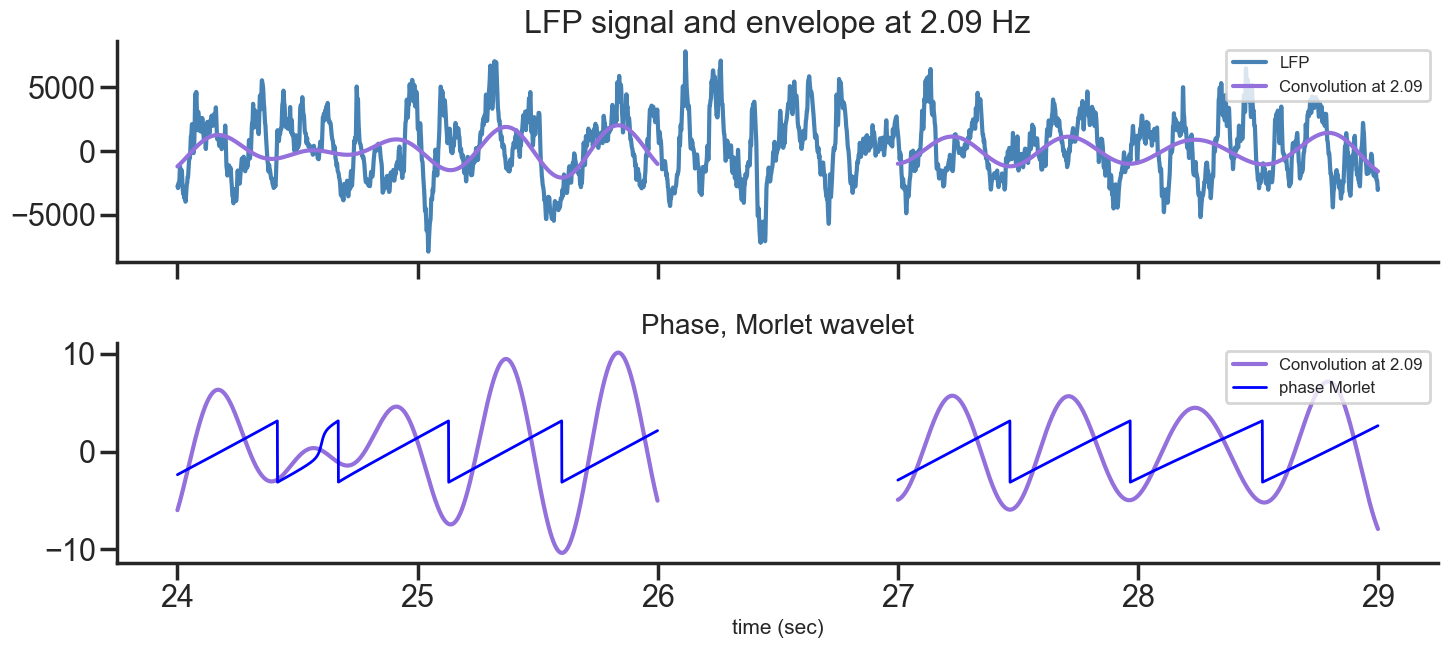

In [40]:
fs = 1250  # sampling frequency 
f_idx = 0  # frequency index
scaling = 100     # scaling for 1st plot 
scaling2 = 1e5   # scaling for 2nd plot 
f = freq[f_idx]   #

T = 26 # time point in sec 
step = 2*fs # length of the segment 

duration = 2 +2*step
t = np.arange(0, duration, 1/fs)

start = T*fs - step
end = (T+1)*fs + step

# print(rep_mask_B_CA1[minute,start:end,ch])
""" Plot Figure """

# Plot the sin function, the phase, and the Morlet transform
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.set_size_inches(15, 7)

# Sin function
axs[0].set_title('LFP signal and envelope at {:.2f} Hz'.format(f), fontsize=23)
axs[0].plot(t[start:end],lfp_B_CA1[minute,start:end,ch], label='LFP',color='steelblue')
axs[0].plot(t[start:end],conv_B_up[minute,start:end, ch, f_idx]/scaling/5, label='Convolution at {:.2f}'.format(f),color='mediumpurple')
axs[0].legend(fontsize=12, loc='upper right')

# Instantaneous phase Morlet
axs[1].set_title('Phase, Morlet wavelet', fontsize=20)
axs[1].plot(t[start:end],conv_B_up[minute,start:end, ch, f_idx]/scaling2, label='Convolution at {:.2f}'.format(f),color='mediumpurple')
axs[1].plot(t[start:end],phase_B_up[minute,start:end, ch, f_idx], label='phase Morlet', color='blue', linewidth=2)
axs[1].legend(fontsize=12, loc='upper right')

# plt.xlim([12.5,15.5])
# Adjust layout
plt.xlabel('time (sec)', fontsize=15)
plt.tight_layout()
plt.show()

### 4.C Downsample phase to 250 Hz -- original phase at 1250 Hz

In [41]:
rep_mask_B_CA1.shape

(20, 75000, 10)

In [42]:
# baseline
phase_B = phase_B_up[:,::5,:,:]
mask_Bd = rep_mask_B_CA1[:,::5,:] 
# low dose
phase_L = phase_L_up[:,::5,:,:]
mask_Ld = rep_mask_L_CA1[:,::5,:] 
# mid dose
phase_M = phase_M_up[:,::5,:,:]
mask_Md = rep_mask_M_CA1[:,::5,:] 
# high dose 
phase_H = phase_H_up[:,::5,:,:]
mask_Hd = rep_mask_H_CA1[:,::5,:] 
phase_B.shape

(20, 15000, 10, 70)

## D. Phase-Frequency plots for each epoch

### 1.D Reshape phase in (entire period length, ch, frequency), period length is 20 min!

In [44]:
phase_BR = phase_B.reshape(-1,phase_B.shape[2],phase_B.shape[3])   # (T, ch, freq)
mask_BR = mask_Bd.reshape(-1,mask_Bd.shape[2])   # (T, ch)

phase_LR = phase_L.reshape(-1,phase_L.shape[2],phase_L.shape[3])   # (T, ch, freq)
mask_LR = mask_Ld.reshape(-1,mask_Ld.shape[2])   # (T, ch)

phase_MR = phase_M.reshape(-1,phase_M.shape[2],phase_H.shape[3])   # (T, ch, freq)
mask_MR = mask_Md.reshape(-1,mask_Md.shape[2])   # (T, ch)

phase_HR = phase_H.reshape(-1,phase_H.shape[2],phase_H.shape[3])   # (T, ch, freq)
mask_HR = mask_Hd.reshape(-1,mask_Hd.shape[2])   # (T, ch)

phase_BR.shape, mask_BR.shape, mask_BR.shape[0]/250/20

((300000, 10, 70), (300000, 10), 60.0)

In [45]:
idx_cell_hpc

array([158, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209], dtype=int64)

### ** 2.D Pick a cell for the spiking

In [48]:
idx = 0 # index for cell and LFP 
cell = idx_cell_hpc[idx]
# lfp_ch = spk[2][idx_cell_hpc[idx]] # lfp_channel
# print('- cell:', cell, '| lfp ch:', lfp_ch)
print('- cell:', cell, ', total number of cells in CA1 is: ', idx_cell_hpc.size)

print('For the 4 epochs: spk length {}, phase length {}'.format(
spk[0][cell].shape, phase_BR.shape[0]*4 + phase_BR.shape[0]/2*4))

- cell: 158 , total number of cells in CA1 is:  49
For the 4 epochs: spk length (1800499,), phase length 1800000.0


### 3.D Get spike activity for each epoch (20 min of activity), for a single cell

In [49]:
fs = 250 # final sampling frequency for speed, phase, lfp
L = phase_BR.shape[0] # length of one trimmed epoch, 20 min 

# baseline, starting at min 5
shift = 5*60*fs # 5 min shift at the beginning of the epoch, in numb of points
spk_epoch_B = spk[0][cell][shift:shift+L]
# Low dose, starting at min 35
shift = 35*60*fs # 5 min shift at the beginning of the epoch, in numb of points
spk_epoch_L = spk[0][cell][shift:shift+L]
# Mid dose, starting at min 65
shift = 65*60*fs # 5 min shift at the beginning of the epoch, in numb of points
spk_epoch_M = spk[0][cell][shift:shift+L]
# High dose, starting at min 95
shift = 95*60*fs # 5 min shift at the beginning of the epoch, in numb of points
spk_epoch_H = spk[0][cell][shift:shift+L]

spk_epoch_H.shape
print('SPIKE COUNT for cell, both low speed and high speed trials') 
print('Across epochs: ', np.sum(spk[0][cell]))
print('Baseline',np.sum(spk_epoch_B))
print('Low dose:',np.sum(spk_epoch_L))
print('Mid dose:',np.sum(spk_epoch_M))
print('High dose:',np.sum(spk_epoch_H))

SPIKE COUNT for cell, both low speed and high speed trials
Across epochs:  47851
Baseline 1189
Low dose: 7551
Mid dose: 12414
High dose: 12280


### Function to compute the 2D phase-frequency map for lfp-spike in each epoch

In [50]:
"""
Compute the 2D map of frequency vs phase for the LFP-spike coupling 
Input: 
- phase of a single epoch (20 min long)
- mask for the same epoch for low speed LFP (20 min long)
- spike activity for the same epoch (20 min long)
Output:
- 2D map (freq, phase), with phase in [0, 360] degree
"""
def freq_phase_map(phase, mask_R, spk_epoch, ch):
    
    not_nan = np.where(mask_R[:,ch])[0] # Indexes for LFP low speed values
    n_freq = phase.shape[2] # number of frequencies 

    hist_list = []
    for f in range(n_freq):

        # phase values for not NaN (i.e. masked lfp) -- i.e. phase for low speed trials 
        phase_deg = np.degrees(phase[not_nan,ch,f])
        # Convert radiants to degrees in the range of 0 to 360
        phase_deg_adj = np.where(phase_deg < 0, phase_deg + 360, phase_deg)

        hist, bin_edges = np.histogram(phase_deg_adj, bins=36, range=[0, 360], weights=spk_epoch[not_nan])
        hist_list.append(hist)
        hist_arr = np.array(hist_list)
    print('spike count, low speed only',np.sum(spk_epoch[not_nan]))
    return hist_arr, bin_edges

### 4.D Compute phase-frequency maps for all the epochs

In [67]:
start_time = time.time()

ch = 1

hist_arr_B, bin_edges_B = freq_phase_map(phase_BR, mask_BR, spk_epoch_B, ch)
hist_arr_L, bin_edges_L = freq_phase_map(phase_LR, mask_LR, spk_epoch_L, ch)
hist_arr_M, bin_edges_M = freq_phase_map(phase_MR, mask_MR, spk_epoch_M, ch)
hist_arr_H, bin_edges_H = freq_phase_map(phase_HR, mask_HR, spk_epoch_H, ch)

# normalization factor for the PDF frequency-phase
norm_B = np.sum(hist_arr_B, axis=1)[0]
norm_L = np.sum(hist_arr_L, axis=1)[0]
norm_M = np.sum(hist_arr_M, axis=1)[0]
norm_H = np.sum(hist_arr_H, axis=1)[0]

norm = np.max([np.sum(hist_arr_B, axis=1)[0], np.sum(hist_arr_L, axis=1)[0], np.sum(hist_arr_M, axis=1)[0], np.sum(hist_arr_H, axis=1)[0]])

time_taken = time.time() - start_time
print(f"Time of execution {time_taken} in sec")

spike count, low speed only 1124
spike count, low speed only 6617
spike count, low speed only 10871
spike count, low speed only 10355
Time of execution 42.68986678123474 in sec


### 5.D Plot map for One Epoch only

[ 0  5 10 15 20 25 30 35] [  0.  50. 100. 150. 200. 250. 300. 350.]


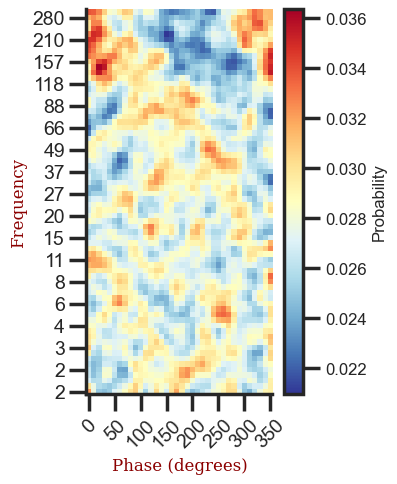

array([1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124, 1124,
       1124, 1124, 1124, 1124], dtype=int64)

In [68]:
step = 5 # distance between phase values on x axis
step_f = 4 # distance between frequency values on y axis

hist_arr = hist_arr_B
bin_edges = bin_edges_B

row_totals = np.sum(hist_arr, axis=1)

pdf = hist_arr / row_totals[:, np.newaxis]
pdf_sm = gaussian_filter(np.nan_to_num(pdf), sigma=0.9)

# Plotting the heatmap
plt.figure(figsize=(3,5))
plt.imshow(pdf_sm, cmap='RdYlBu_r', interpolation='nearest', origin='lower',aspect='auto')

bin_values = bin_edges[:-1]
bins = bin_values[::step]
xticks = np.arange(0,bin_edges[:-1].size,step)
print(xticks,bins)

plt.xticks(ticks=xticks, labels=['{:d}'.format(int(b)) for b in bins ],rotation=45, fontsize=14)
plt.yticks(ticks=np.arange(0, len(freq),step_f), labels=['{:d}'.format(int(f)) for f in freq[::step_f]],fontsize=14)
cbar = plt.colorbar(label='Spike count')
cbar.set_label('Probability', fontsize=12)  # Set a smaller font size for the label

cbar.ax.tick_params(labelsize=12)

# Adding axis labels with a custom font
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
       }
plt.xlabel('Phase (degrees)', fontdict=font)
plt.ylabel('Frequency', fontdict=font)

plt.show()
row_totals

### Function to calculate normalized spike count (Gauss smoothed), and subplot function

In [69]:
""" -------------------------------------------------------
Calculate normalized spiking count for each epoch
and Gaussian smoothed spiking count in the phase-frequency space
"""
# Define a function to calculate PDF and smoothed PDF
def calculate_pdf_sm(hist_arr, norm, sigma):
    pdf = hist_arr / norm # normalize histogram count with max count across epochs 
    pdf_sm = gaussian_filter(np.nan_to_num(pdf), sigma=sigma)
    return pdf, pdf_sm


""" -------------------------------------------------------
Plot subplots for the phase-frequency LFP-spike coupling for all the 4 epochs together
""" 
def setup_subplot(ax, pdf, pdf_sm, smooth, bin_edges, step_x, step_f, title, label_font, show_y_axis, bar_name, vmin, vmax):
    
    if smooth: distribution = pdf_sm 
    else: distribution = pdf
    
    # vmin = np.nanmin(distribution)
    # vmax = np.nanmax(distribution)
    
    print('vmin local', vmin)
    print('vmax local',vmax)
    
    cax = ax.imshow(1.*distribution, cmap='RdYlBu_r', interpolation='nearest', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    bin_values = bin_edges[:-1]
    bins = bin_values[::step_x]
    xticks = np.arange(0, bin_edges[:-1].size, step_x)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['' if i % 2!=0 else '{:d}'.format(int(b)) for i, b in enumerate(bins)], rotation=45, fontsize=14)

    ax.set_yticks(np.arange(0, len(freq), step_f))
    if show_y_axis:
        ax.set_yticklabels(['{:d}'.format(int(f)) for f in freq[::step_f]], fontsize=14)
        ax.set_ylabel('Frequency (Hz)', fontdict=label_font)
    else:
        ax.set_yticklabels([])
        
    ax.spines['left'].set_linewidth(0.5)  # Adjust the left spine thickness
    ax.spines['bottom'].set_linewidth(0.5)  # Adjust the bottom spine thickness
    
    ax.tick_params(axis='both', which='major', width=1, length=7)  # Change '2' to your desired thickness
    ax.set_title(title, fontdict=title_font)
    ax.set_xlabel('Phase (deg)', fontdict=label_font)
    
    
    # cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=axes.ravel().tolist(), pad=0.01, aspect=20)
    # cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=vmin, vmax=vmax)), pad=0.01, aspect=20)

    if bar_name: 
        cbar = fig.colorbar(cax, ax=ax, cmap='RdYlBu_r', format='%.3f')
        cbar.set_label('Probability', fontsize=12)
        cbar.ax.tick_params(labelsize=9,  width=1, length=7) 
        cbar.outline.set_linewidth(0.5)
    
    
""" -------------------------------------------------------
Save phase-frequency plot for the 4 epochs together 
"""
def save_figures_freq_phase(fig, rec, sess, brain_reg, cell, layer_dir, layer_acr):

    main_dir = r'C:\Users\fentonlab\Desktop\Gino\LFPs\HPC'
    path = rec[sess][brain_reg]

    dir_sess = path.split('\\')[-3]     # path for session directory
    full_dir_path = os.path.join(main_dir, dir_sess, 'Figures\\freq_phase', layer_dir)
    
    if not os.path.exists(full_dir_path):
        os.makedirs(mfull_dir_path)
    
    file_name = os.path.join(full_dir_path,'sess_{}_{}_cell_{}_freq_phase_300_Hz_CSD.pdf'.format(sess, layer_acr, cell))
    fig.savefig(file_name, dpi=300)
    file_name = os.path.join(full_dir_path,'sess_{}_{}_cell_{}_freq_phase_300_Hz_CSD.png'.format(sess, layer_acr, cell))
    fig.savefig(file_name, dpi=300)
    
    
""" -------------------------------------------------------
Save Spike-Count histogram
"""
def save_spike_count_hist(fig, rec, sess, brain_reg, cell, layer_dir, layer_acr):

    main_dir = r'C:\Users\fentonlab\Desktop\Gino\LFPs\HPC'
    path = rec[sess][brain_reg]

    dir_sess = path.split('\\')[-3]     # path for session directory
    full_dir_path = os.path.join(main_dir, dir_sess, 'Figures\\freq_phase', layer_dir)
    
    if not os.path.exists(full_dir_path):
        os.makedirs(full_dir_path)
    
    file_name = os.path.join(full_dir_path,'sess_{}_{}_cell_{}_spike_count_hist_CSD.pdf'.format(sess, layer_acr, cell))
    print(file_name)
    fig.savefig(file_name, dpi=300)
    file_name = os.path.join(full_dir_path,'sess_{}_{}_cell_{}_spike_count_hist_CSD.png'.format(sess, layer_acr, cell))
    fig.savefig(file_name, dpi=300)

### 6.D Plot map for All Epochs

vmin  0.021400552797713846 vmax 0.035634885539909227
vmin local 0.021400552797713846
vmax local 0.035634885539909227
vmin local 0.021400552797713846
vmax local 0.035634885539909227
vmin local 0.021400552797713846
vmax local 0.035634885539909227
vmin local 0.021400552797713846
vmax local 0.035634885539909227


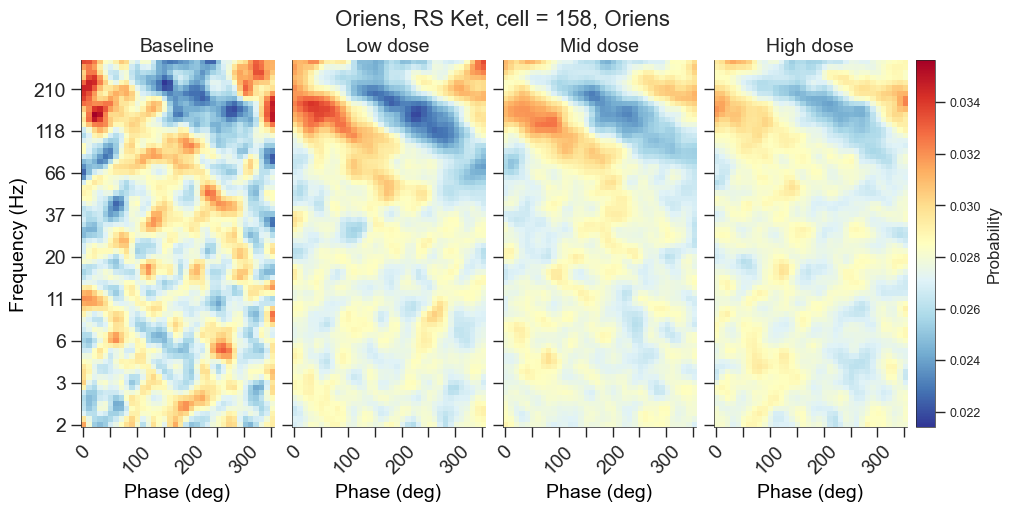

In [70]:
step_x = 5
step_f = 8

layer = "Oriens"

smooth = True  # smoothing
sigma = 1   # sigma for smoothing 

norm_tot = norm_B + norm_L + norm_M + norm_H
# Calculate PDFs
pdf_B, pdf_sm_B = calculate_pdf_sm(hist_arr_B, norm_B, sigma)
pdf_L, pdf_sm_L = calculate_pdf_sm(hist_arr_L, norm_L, sigma)
pdf_M, pdf_sm_M = calculate_pdf_sm(hist_arr_M, norm_M, sigma)
pdf_H, pdf_sm_H = calculate_pdf_sm(hist_arr_H, norm_H, sigma)

# # Determine the global min and max values for the color scale

vmin = min(np.nanmin(pdf_sm_B), np.nanmin(pdf_sm_L), np.nanmin(pdf_sm_M), np.nanmin(pdf_sm_H))
vmax = max(np.nanmax(pdf_sm_B), np.nanmax(pdf_sm_L), np.nanmax(pdf_sm_M), np.nanmax(pdf_sm_H))
print('vmin ', vmin, 'vmax', vmax)

# Create 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 5), constrained_layout=True) # Adjust the figsize as needed

# Define a common font for titles
title_font = {'family': 'sans-serif','fontsize': 14}
label_font = {'family': 'sans-serif', 'color':  'black', 'weight': 'ultralight', 'size': 14}

# Plot each histogram
setup_subplot(axes[0], pdf_B, pdf_sm_B, smooth, bin_edges_B, step_x, step_f, 'Baseline', label_font, True, False, vmin, vmax)
setup_subplot(axes[1], pdf_L, pdf_sm_L, smooth, bin_edges_L, step_x, step_f, 'Low dose', label_font, False, False,vmin, vmax)
setup_subplot(axes[2], pdf_M, pdf_sm_M, smooth, bin_edges_M, step_x, step_f, 'Mid dose', label_font, False, False,vmin, vmax)
setup_subplot(axes[3], pdf_H, pdf_sm_H, smooth, bin_edges_H, step_x, step_f, 'High dose', label_font, False, True, vmin, vmax)

# Add a common color bar for all subplots
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=axes.ravel().tolist(), pad=0.01, aspect=20)
# cbar.set_label('Probability', fontsize=12)
# cbar.ax.tick_params(labelsize=10,  width=1, length=7) 
# cbar.outline.set_linewidth(0.5)

fig.suptitle(f'{layer}, RS Ket, cell = {cell}, {layer} ', fontsize=16, fontweight='regular')
plt.show()

# save_figures_freq_phase(fig, rec,sess, 'HPC', cell, layer_dir, layer_acr)

### 6.E Spiking count across epochs

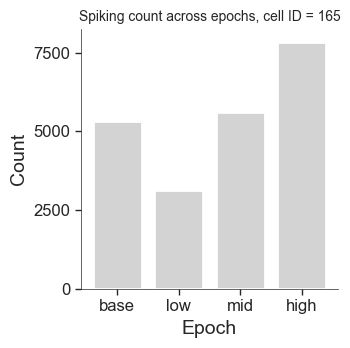

C:\Users\fentonlab\Desktop\Gino\LFPs\HPC\2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk\Figures\freq_phase\locmol\sess_2_LM_cell_165_spike_count_hist_CSD.pdf


meta NOT subset; don't know how to subset; dropped


In [581]:
bin_edges = [0, 1, 2, 3]  
spike_count = [np.sum(hist_arr_B, axis=1)[0], np.sum(hist_arr_L, axis=1)[0], np.sum(hist_arr_M, axis=1)[0], np.sum(hist_arr_H, axis=1)[0]]
bins = range(len(spike_count))

# Plot bars
fig = plt.figure(figsize=(4,4))
plt.bar(bins, spike_count, edgecolor='white', color='lightgrey', align='center')

plt.title('Spiking count across epochs, cell ID = {}'.format(cell), fontsize=10)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(ticks=bins, labels=["base","low","mid","high"],fontsize=12)
plt.yticks(fontsize=12)

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(0.5)
plt.gca().tick_params(axis='x', length=4, width=1)
plt.gca().tick_params(axis='y', length=4, width=1)

plt.tight_layout()
plt.show()

save_spike_count_hist(fig, rec, sess, 'HPC', cell, layer_dir, layer_acr)

In [938]:
print("Default font family:", plt.rcParams['font.family'])
print("Default font size:", plt.rcParams['font.size'])

Default font family: ['sans-serif']
Default font size: 24.0


In [939]:

# Calculate the histogram, using spike counts as weights
hist_B, bin_edges = np.histogram(phase_B, bins=30, range=[0, 360], weights=spk[0][cell][0:epoch_length].reshape(-1, 1))
hist_L, bin_edges = np.histogram(phase_L, bins=30, range=[0, 360], weights=spk[0][cell][0:epoch_length].reshape(-1, 1))
hist_M, bin_edges = np.histogram(phase_M, bins=30, range=[0, 360], weights=spk[0][cell][0:epoch_length].reshape(-1, 1))
hist_H, bin_edges = np.histogram(phase_H, bins=30, range=[0, 360], weights=spk[0][cell][0:epoch_length].reshape(-1, 1))


NameError: name 'epoch_length' is not defined

In [ ]:
hist_B, hist_L, hist_M, hist_H

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist_B, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.45)
plt.bar(bin_edges[:-1], hist_L, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.45)
plt.bar(bin_edges[:-1], hist_M, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.45)
plt.bar(bin_edges[:-1], hist_H, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha=0.45)
plt.xlabel('Instantaneous Phase (degrees)')
plt.ylabel('Spike Count')
plt.title('Histogram of Spike Counts over LFP Instantaneous Phase')
plt.show()

In [ ]:
# filter Lfp at a given epoch 
# lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H = filter_lfp_in_each_epoch_and_frequency(Lfp_B_min, Lfp_L_min, Lfp_M_min, Lfp_H_min, 1, 4, gain)
# phase_B_freq, phase_L_freq, phase_M_freq, phase_H_freq = instananeoues_phase_epoch(lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H) 
# phase_B.append(phase_B_freq)

In [582]:
spk[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [164]:
pwd

'C:\\Users\\fentonlab\\Desktop\\Gino\\Gino_codes\\python'

### Define function to identify place cells through firing rate maps

In [41]:
# CELL Properties 
# OUTPUT:
# occupation map, 
# rate_maps_temp (rate firing map -- raw, not smoothed)
# rate_maps_sm (rate firing map -- smoothed)
# LinMapsTemp_temp (rate firing map in 1D)

def place_cell_properties(spk_data, beh_data, binsxy, fsrate, shuf_state):
    from scipy.ndimage import gaussian_filter

    occ, rate_maps_sm, rate_maps_temp, LinMapsTemp_temp, p_info, coh = [], [], [], [], [], []
    nRepeat = 50  # number of shuffles

    # COMPUTING THE RATE MAPS
    occ = np.histogram2d(beh_data[0], beh_data[1], bins=binsxy)[0] / fsrate
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(1, 1, 1)
    sns.heatmap(occ, cmap='jet', ax=ax)    
    plt.show()
    
    # raw firing rate map
    rate_maps_temp = [np.histogram2d(beh_data[0], beh_data[1], bins=binsxy, weights=s)[0]
                      / occ for s in spk_data]
    
#     ## radial version
#     Xcenter = beh_data[0] - (np.nanmax(beh_data[0]) + np.nanmin(beh_data[1])) / 2
#     Ycenter = beh_data[1] - (np.nanmax(beh_data[1]) + np.nanmin(beh_data[0])) / 2
    
#     alpha = np.arctan2(Ycenter, Xcenter)

#     L_occ = np.histogram(alpha, bins=binsxy)[0] /fsrate
    # LinMapsTemp_temp = [np.histogram(alpha, bins=30, weights=s)[0] / L_occ
    #      for s in spk_data]
    
    # get NaN index 
    idx_nan = [np.isnan(p) for p in rate_maps_temp]

    # smooth map 
    rate_maps_sm = [gaussian_filter(np.nan_to_num(p), sigma=1) for p in rate_maps_temp] # not higher than 1.5
    
    for icell in range(0,len(rate_maps_sm)):
        
        rate_maps_sm[icell][idx_nan[icell]] = np.nan
        


    # analyze rate maps
    p_info = [place_info_content(occ, m) for m in rate_maps_temp]
    coh = [neighbor_sum(m) for m in rate_maps_temp]

    ## pinfo and coherence
    print('Place info', np.hstack(p_info))
    print('Coherence', np.hstack(coh))

#     # plot firing rate maps
#     for icell in range(0,len(rate_maps_sm)):
#         print('p_info',p_info[icell],'coherence',coh[icell])
#         fig = plt.figure(figsize=(2, 2))
#         ax = fig.add_subplot(1, 1, 1)
#         sns.heatmap(rate_maps_sm[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
#         ax.set_xlabel('X position')
#         ax.set_ylabel('Y position')
#         fname = 'Cell' + str(icell)
#         ax.set_title(fname)
#         plt.show()        
    
    
    if shuf_state == True:
        # Randomizing
        sTrackedCopy = spk_data.copy()
        sTrackedTimePairs = list(zip(*sTrackedCopy))

        pInfoShuffled = []
        cohShuffled = []
        for iRand in range(nRepeat):
            np.random.shuffle(sTrackedTimePairs)
            sShuffled = list(zip(*sTrackedTimePairs))

            RateMapsShuffled = [np.histogram2d(beh_data[0], beh_data[1], bins=binsxy, weights=s)[0]
                                / occ for s in sShuffled]
            pInfoShuffled.append([place_info_content(occ, m) for m in RateMapsShuffled])

            cohShuffled.append([neighbor_sum(m) for m in RateMapsShuffled])

        pInfoTest = []
        for p, z in zip(p_info, zip(*pInfoShuffled)):
            Out = [p, (p - np.mean(z)) / np.std(z)]
            pInfoTest.append([Out, Out[0] > 1 and Out[1] > 1.96])

        cohTest = []
        for p, z in zip(coh, zip(*cohShuffled)):
            Out = [p, (p - np.mean(z)) / np.std(z)]
            testTmp = Out[0] > 0.5 and Out[1] > 1.96
            cohTest.append([Out, testTmp])

        # determine whether cells are place cells
        PC_test = [c[0][1] > 1.96 and p[0][1] > 1.96 for c, p in zip(cohTest, pInfoTest)]
        # fr_test = [(np.sum(s)/(s.size/fsrate))<5 for s in spk_data]
        
    if shuf_state == False:
    
        PC_test = [c> 0.4 and p> 0.7 for c, p in zip(coh, p_info)]
        # fr_test = [(np.sum(s)/(s.size/fsrate))<5 for s in spk_data]

    # PC_fr_test = [p*q for p,q in zip(PC_test, fr_test)]    
    PC_fr_test = [p for p in zip(PC_test)]    

    print('number of PCs', np.sum(PC_fr_test), 'of', len(PC_test))

    ## plot firing rate maps
    for icell in np.hstack(np.argwhere(np.hstack(PC_fr_test) == True)):
        print('place information', p_info[icell])
        print('coherence', coh[icell])
        print('firing rate', np.sum(spk_data[icell])/(spk_data[icell].size/fsrate))

        fig = plt.figure(figsize=(2, 2))
        ax = fig.add_subplot(1, 1, 1)
#         sns.heatmap(rate_maps_temp_temp[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
        sns.heatmap(rate_maps_sm[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        fname = 'Cell' + str(icell)
        ax.set_title(fname)
        plt.show()

    return occ, rate_maps_temp, rate_maps_sm, LinMapsTemp_temp, p_info, coh, PC_fr_test



### Identify Place Cells in HPC

In [49]:
spikes_binned_all_HPC[0].shape[1]/250/60

120.03326666666666

experiment C:\Users\fentonlab\Desktop\Tony\Neurotar_HPC_ketamine\SPK\electrophysiology\2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk_HPCprobe


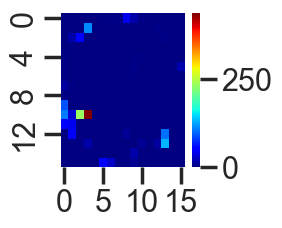

C:\Users\fentonlab\AppData\Local\Temp\ipykernel_26312\2977194271.py:22: RuntimeWarning: invalid value encountered in divide
  rate_maps_temp = [np.histogram2d(beh_data[0], beh_data[1], bins=binsxy, weights=s)[0]


Place info [0.1360883  0.1991988  0.1421569  0.28416554 0.12029715 0.2076099
 0.11876295 0.19815467 0.30385202 0.06074089 0.16363236 0.2417525
 0.47730845 0.72819272 3.71159312 2.05350833 1.45604318 1.77112766
 1.19418658 0.93115875 0.15497903 0.33759181 1.21730222 1.24468757
 0.15705539 0.55651581 0.2825719  1.51306636 0.58613238 1.24528244
 1.44620189 2.16544421 1.34721852 0.10826509 0.04407853 0.04402136
 0.06140433 0.07750166 0.05324693 0.3595172  2.84043548 1.31246028
 0.13435991 1.61978348 1.09181616 0.26344672 0.05369682 0.89056395
 0.10586165 0.3025781  0.93640489 0.11157383 0.15062807 0.05107873
 0.65395016 0.07564108 0.06698947 0.13450051 0.10822657 0.0789317
 0.08791382 0.10944471 0.92665362 1.82929427 0.36699705 0.10820464
 1.39915853 0.47579855 0.10814898 0.07098279 0.06626973 0.23211498
 0.27953959 0.17433342 0.20643805 2.68380439 0.         3.07335105
 0.         1.34123651 0.05026763 0.26531787 0.21585582 0.03929647
 0.12748772 0.35785789 0.08712386 1.36638076 1.4017040

C:\Users\fentonlab\Desktop\Gino\Gino_codes\python\utilities_ketamine_analysis_v8.py:555: RuntimeWarning: divide by zero encountered in log2
  info_map = (occ / T) * (rate_map / R) * np.log2(rate_map / R)
C:\Users\fentonlab\Desktop\Gino\Gino_codes\python\utilities_ketamine_analysis_v8.py:555: RuntimeWarning: invalid value encountered in multiply
  info_map = (occ / T) * (rate_map / R) * np.log2(rate_map / R)
C:\Users\fentonlab\Desktop\Gino\Gino_codes\python\utilities_ketamine_analysis_v8.py:555: RuntimeWarning: invalid value encountered in divide
  info_map = (occ / T) * (rate_map / R) * np.log2(rate_map / R)
C:\Users\fentonlab\.conda\envs\bettinumbers\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


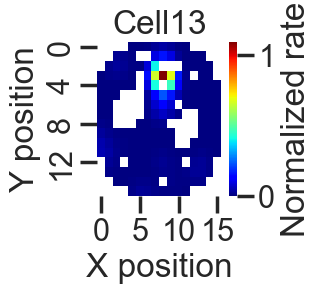

place information 1.7711276562880327
coherence 0.4819375464838577
firing rate 0.008333333333333333


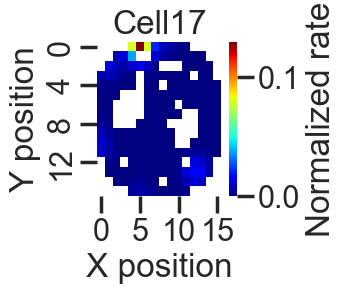

place information 1.194186575663202
coherence 0.40007656654045654
firing rate 0.019444444444444445


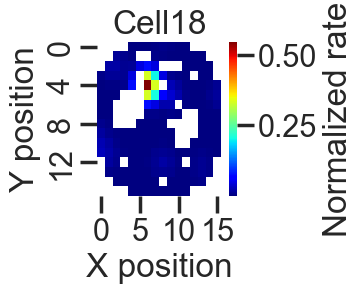

place information 0.9311587488581492
coherence 0.40992664926914835
firing rate 4.526666666666666


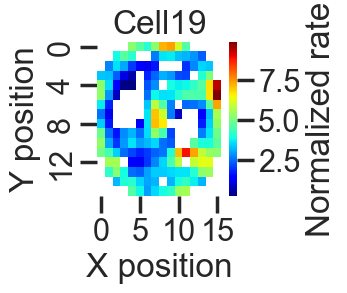

place information 1.2173022200066181
coherence 0.4829055994234113
firing rate 0.013333333333333334


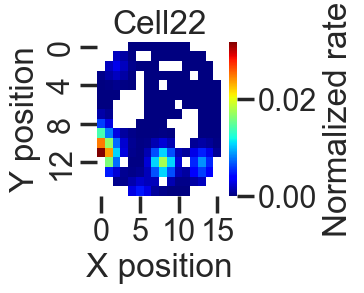

place information 1.2446875731528393
coherence 0.40209022673018285
firing rate 0.006111111111111111


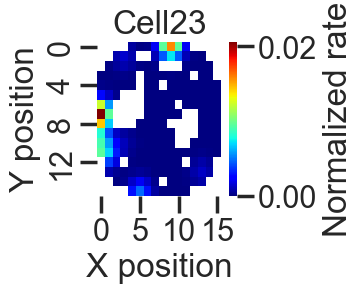

place information 1.5130663598883922
coherence 0.6434098412766421
firing rate 0.008333333333333333


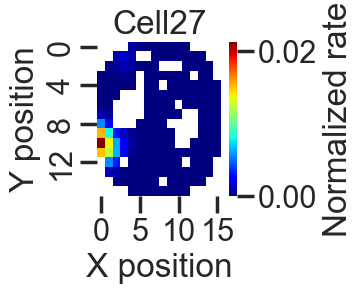

place information 1.4462018913835335
coherence 0.402755926288289
firing rate 0.023333333333333334


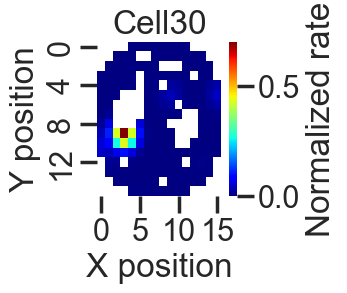

place information 1.347218519083925
coherence 0.4443073460858683
firing rate 0.01


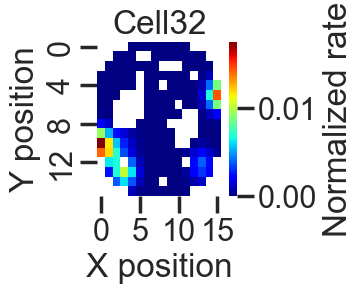

place information 2.8404354794756137
coherence 0.4522228027122113
firing rate 0.0038888888888888888


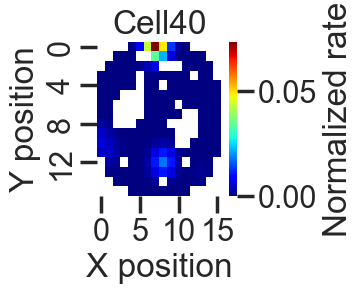

place information 1.3124602786870472
coherence 0.43071634435851575
firing rate 0.03111111111111111


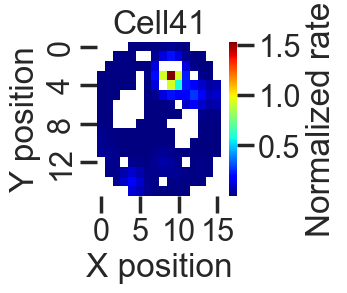

place information 1.3991585285482355
coherence 0.5775709930289832
firing rate 1.7472222222222222


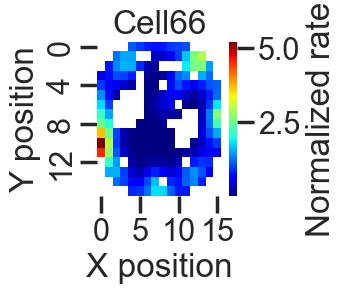

place information 2.6838043865176706
coherence 0.464611648422529
firing rate 0.006666666666666667


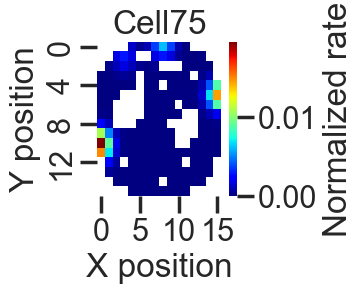

place information 3.0733510520694622
coherence 0.40191645740136916
firing rate 0.0033333333333333335


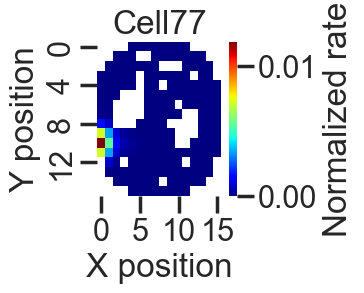

place information 1.3412365128647696
coherence 0.4047725447182811
firing rate 0.0044444444444444444


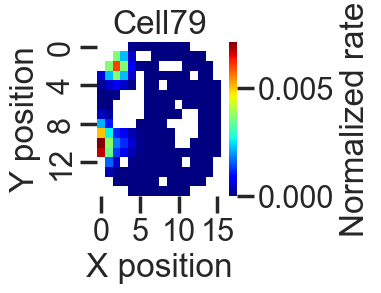

place information 1.4017040746617182
coherence 0.40071879881457717
firing rate 0.03


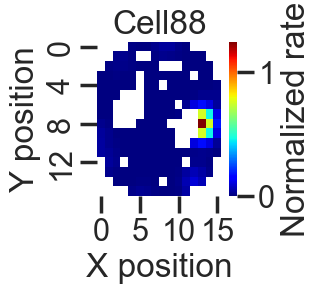

place information 0.894571214266131
coherence 0.5653668338785364
firing rate 0.3472222222222222


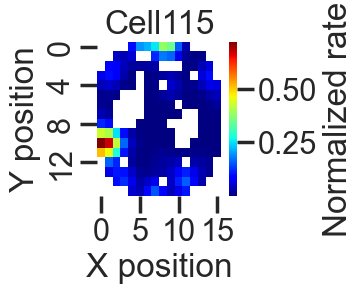

place information 1.336320430028706
coherence 0.5225220504208103
firing rate 0.03777777777777778


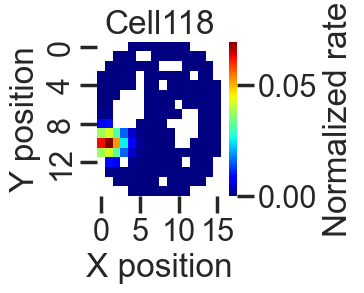

place information 2.8840836669153758
coherence 0.467097640921672
firing rate 0.03888888888888889


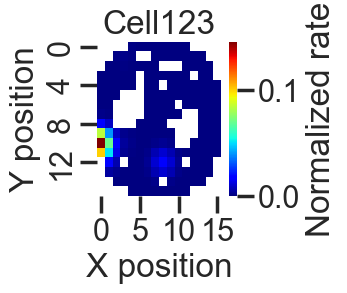

place information 2.7117800884878283
coherence 0.4977564216434994
firing rate 0.013888888888888888


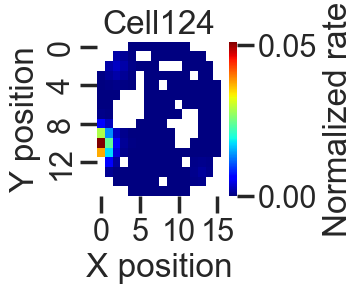

place information 2.0449174504656256
coherence 0.5631747366877953
firing rate 1.085


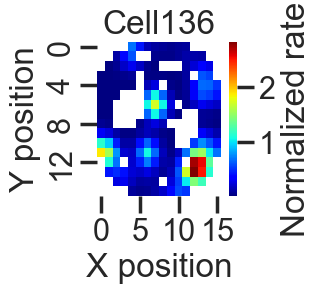

place information 1.4537311629815675
coherence 0.5678382152203342
firing rate 0.013333333333333334


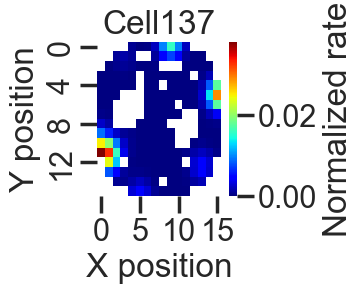

place information 1.2102022223063607
coherence 0.50970444002556
firing rate 0.8311111111111111


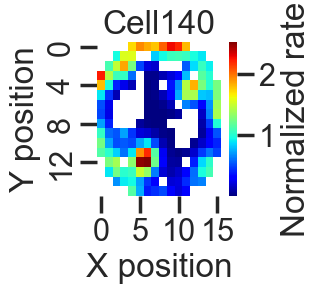

place information 1.6937733112076683
coherence 0.5895761584477796
firing rate 0.6544444444444445


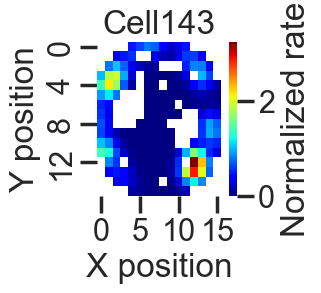

place information 1.558018661664391
coherence 0.41889939540443255
firing rate 0.3016666666666667


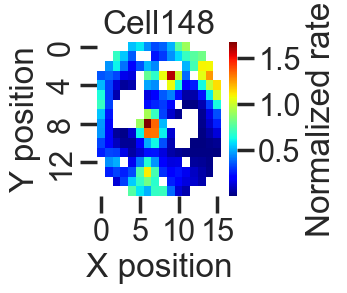

place information 1.3127960498546614
coherence 0.4420991285751766
firing rate 0.01611111111111111


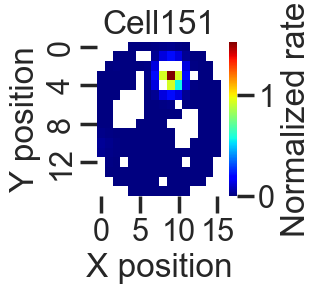

place information 1.406069290454819
coherence 0.40189931940164625
firing rate 0.012222222222222223


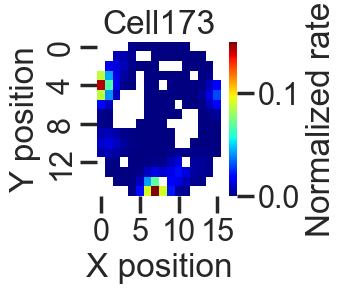

place information 1.5516568166513405
coherence 0.5195350775374272
firing rate 0.009444444444444445


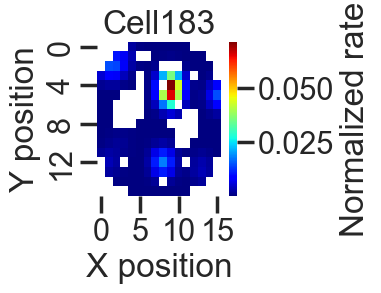

place information 2.5510043165236542
coherence 0.40750015445845034
firing rate 0.0022222222222222222


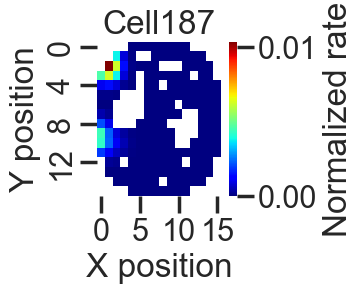

place information 0.9027991851092741
coherence 0.4700584055985589
firing rate 0.10666666666666667


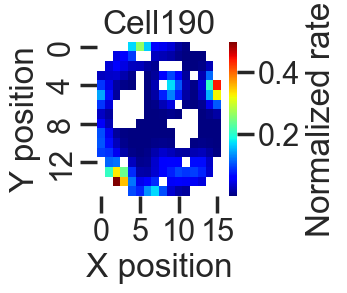

place information 0.8955229477369455
coherence 0.434416628493326
firing rate 0.13777777777777778


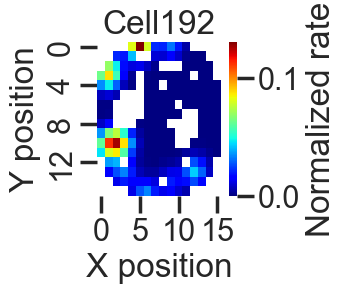

place information 1.5014226091014327
coherence 0.4821938189534889
firing rate 0.0022222222222222222


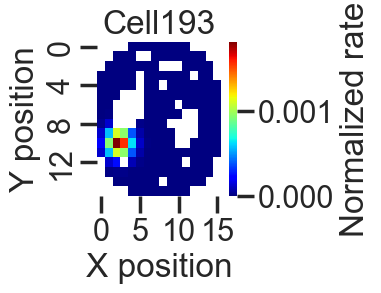

place information 2.146576723089957
coherence 0.43592076778093874
firing rate 0.011666666666666667


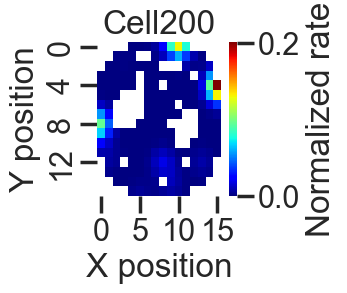

place information 3.665313876135678
coherence 0.4512885555249864
firing rate 0.11555555555555555


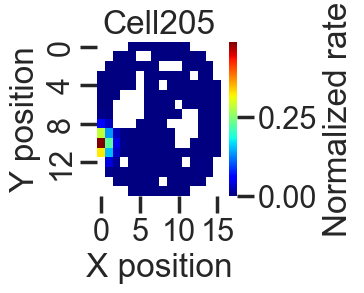

place information 2.250424910352857
coherence 0.4060029945944139
firing rate 0.007222222222222222


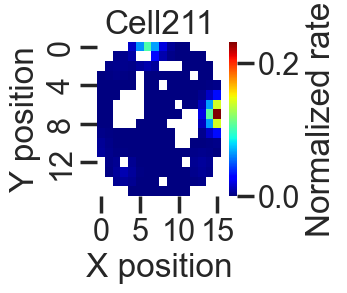

In [50]:
####
bins_position = 16
ls_tmp = []
fr_maps_all = []
PC_test_b_all = []
irec = sess
# for irec in range(0,1): #len(x)):
    
#     if (drug_list[irec] == 'SAL') or (drug_list[irec] == 'PCP') or (drug_list[irec] == 'RSK'):
#     if (mouse_list[irec] == 'M15'):


ksort_path = ksort_HPC_path_matched[irec]
print('experiment',ksort_path)

size_to = []
size_to = np.min([spikes_binned_all_HPC[0].shape[1],beh_binned_all[irec][0].size]) - 1



# # baseline
start = 0
end = 30*60*250
occ_b, rate_maps_temp_b, rate_maps_temp_b_sm, LinMapsTemp_temp, p_info_b, coh_b, PC_test_b = [], [],[],[],[],[],[]   
occ_b, rate_maps_temp_b, rate_maps_temp_b_sm, LinMapsTemp_temp, p_info_b, coh_b, PC_test_b = place_cell_properties(spikes_binned_all_HPC[0][:,start:end],
                                                                  np.array([beh_binned_all[irec][0][start:end],
                                                                            beh_binned_all[irec][1][start:end]]),
                                                                            bins_position,250,False)

PC_test_b_all.append(PC_test_b)

In [447]:
# Save current print options
saved_options = np.get_printoptions()
# Set the print options to display the full array without truncation
np.set_printoptions(threshold=100)
# Restore the original print options
np.set_printoptions(**saved_options)

In [448]:
spk_short[0:5,0:250*60]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

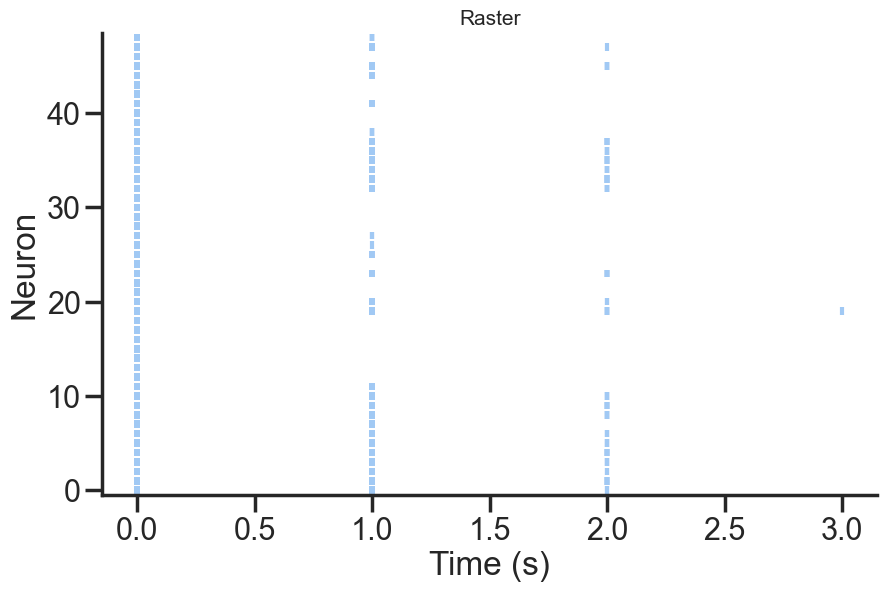

In [440]:
nCells = spk_short.shape[0]

# Create lists to hold the x and y values for the spikes
spike_times_x = []
spike_neurons_y = []


# Plot all spikes at once
plt.figure(figsize=(10, 6))
plt.eventplot(spk_short[:,0:250*60], linelengths=0.8)

# Set the limits and labels
plt.ylim(-0.5, nCells - 0.5)
plt.xlabel('Time (s)')
plt.ylabel('Neuron')

# Add y-ticks to show neuron numbers
plt.yticks(np.arange(0,nCells,10))
plt.yticks(np.arange(0,nCells,10))

# Show the raster plot
plt.title('Raster', fontsize=15)
plt.show()

In [307]:
np.arange(0,len(bin_edges) - 1, 5)

array([ 0,  5, 10, 15, 20, 25])

In [312]:
bin_edges[::5]

array([  0.,  60., 120., 180., 240., 300., 360.])

In [325]:
bins = np.round(bin_edges[:-1], 2)
bins[::5]

array([  0.,  60., 120., 180., 240., 300.])

In [330]:
hist_B_arr

array([[ 7,  8,  6,  8,  6,  6,  9,  5,  9,  5,  4,  3,  4,  7,  8, 10,
         4,  7,  5,  8,  5,  8, 10, 10,  6,  6,  6,  5,  4, 14],
       [ 8,  7,  7,  7,  6,  8,  3,  6,  5,  2,  6,  8, 12,  9,  8,  3,
         5, 10, 12,  8,  5,  2,  8, 11,  8,  7,  3,  2,  7, 10],
       [ 8,  7,  5,  7,  4, 10,  4,  7,  2,  6,  4,  5, 10,  7,  7,  9,
         2,  7,  5,  7, 10,  7, 14,  9,  4,  8,  6,  7,  7,  8],
       [ 9,  3,  8,  6,  9,  6, 11,  4,  8,  3,  6,  5,  8,  9,  8,  7,
         5,  5, 10, 11,  2,  9,  6,  6,  6,  8,  5,  6,  8,  6],
       [ 4,  9, 11,  7,  9,  8,  8,  6,  7,  7,  5,  7,  6,  5,  4,  2,
         3,  7,  5,  9,  8,  6, 11,  8,  7, 10,  6,  8,  3,  7],
       [12,  7,  4,  6, 13,  7,  6, 10,  4,  7,  7,  6,  7,  8,  6,  6,
         2,  6,  5,  4,  1,  8,  6, 13,  9,  5,  6,  5, 11,  6],
       [ 5,  9,  6,  6,  9,  7, 12,  3,  2,  2,  5,  8, 11,  6, 10,  3,
         6,  6,  7,  4,  9,  4,  9,  4,  5,  8, 11,  4, 15,  7],
       [10,  4,  8,  5,  7,  8,  4,  7,  

In [192]:
epoch_length = 250*60*30
# filter Lfp at a given epoch and 
lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H = filter_lfp_in_each_epoch_and_frequency(Lfp_B[:,lfp_ch].reshape(-1, 1), Lfp_L[:,lfp_ch].reshape(-1, 1), Lfp_M[:,lfp_ch].reshape(-1, 1), Lfp_H[:,lfp_ch].reshape(-1, 1), 1, 4, gain)
phase_B, phase_L, phase_M, phase_H = instananeoues_phase_epoch(lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H) 

lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H = filter_lfp_in_each_epoch_and_frequency(Lfp_B[:,lfp_ch].reshape(-1, 1), Lfp_L[:,lfp_ch].reshape(-1, 1), Lfp_M[:,lfp_ch].reshape(-1, 1), Lfp_H[:,lfp_ch].reshape(-1, 1), 1, 4, gain)

Filtering Lfp ...


In [196]:
lfp_filt_B.shape

(450000, 1)

In [197]:
phase_B, phase_L, phase_M, phase_H = instananeoues_phase_epoch(lfp_filt_B, lfp_filt_L, lfp_filt_M, lfp_filt_H)

In [202]:
spk[0][cell][0:epoch_length].shape

(450000,)

In [ ]:
LinMapsTemp_temp = [np.histogram(alpha, bins=30, weights=s)[0] / L_occ
    #      for s in spk_data]

In [104]:
spk[0][0][0:1500]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

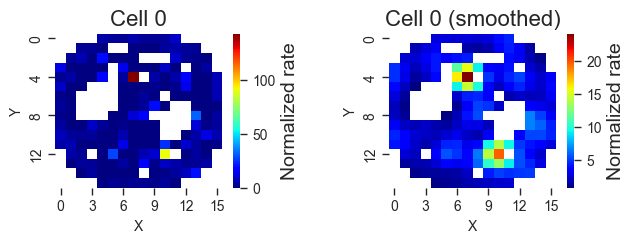

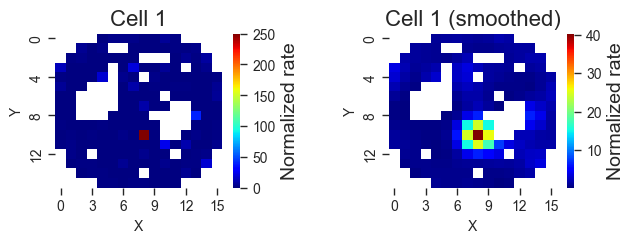

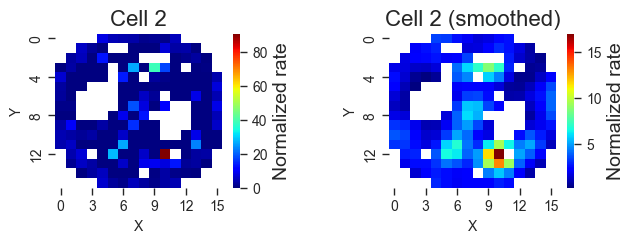

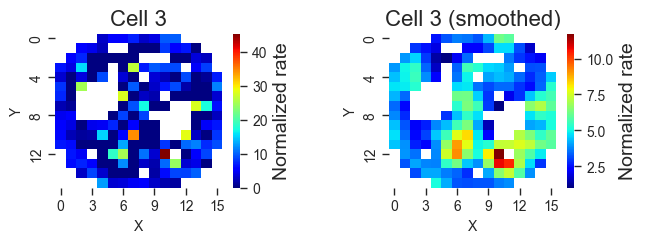

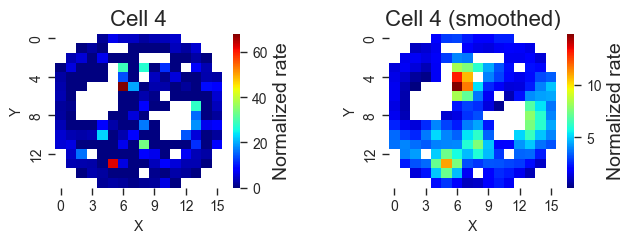

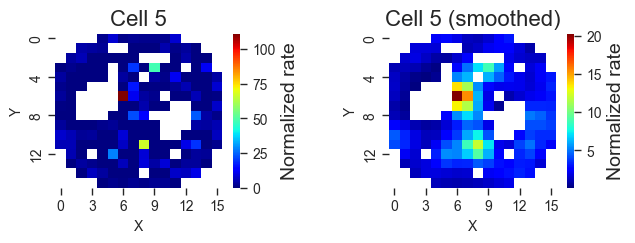

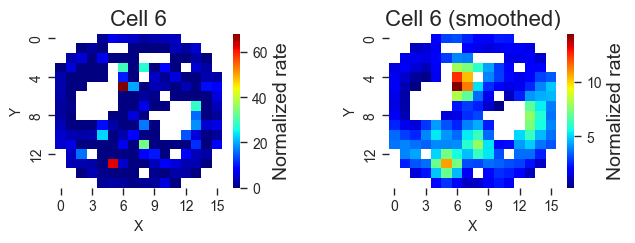

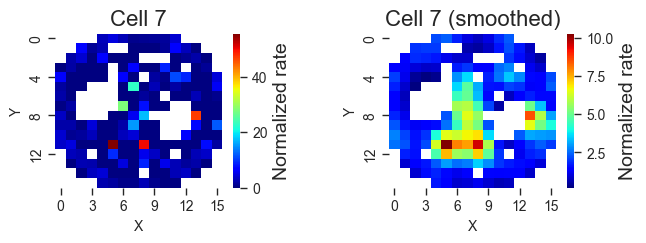

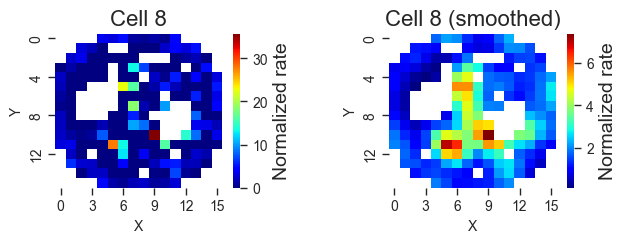

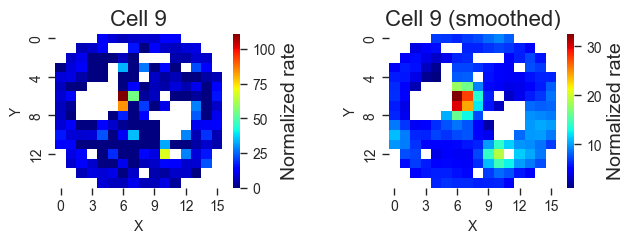

In [56]:
# ## plot firing rate maps
# for icell in range(0,len(rate_maps_temp_b)):
#     fig = plt.figure(figsize=(2, 2))
#     ax = fig.add_subplot(1, 1, 1)
#     sns.heatmap(rate_maps_temp_b[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
#     ax.set_xlabel('X position')
#     ax.set_ylabel('Y position')
#     fname = 'Cell' + str(icell)
#     ax.set_title(fname)
#     plt.show()   
    

for icell in range(0,10): #len(rate_maps_temp_b)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 2))
    
    # Plot for the first column
    heatmap1 = sns.heatmap(rate_maps_temp_b[icell], cmap='jet', ax=axes[0], cbar_kws={'label': 'Normalized rate'})
    axes[0].set_xlabel('X',fontsize=10)
    axes[0].set_ylabel('Y',fontsize=10)
    axes[0].tick_params(axis='both', labelsize=10, width=1, length=5)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=10)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=10)
    axes[0].set_title('Cell ' + str(icell), fontsize=16)
    
    cbar = heatmap1.collections[0].colorbar
    cbar.set_label('Normalized rate', size=14)  # Set the font size for 'Normalized rate'
    cbar.ax.tick_params(labelsize=10, width=1, length=5)

    # Plot for the second column (assuming a replication of the first for demonstration)
    heatmap2 = sns.heatmap(rate_maps_temp_b_sm[icell], cmap='jet', ax=axes[1], cbar_kws={'label': 'Normalized rate'})
    axes[1].set_xlabel('X',fontsize=10)
    axes[1].set_ylabel('Y',fontsize=10)
    axes[1].tick_params(axis='both', labelsize=10, width=1, length=5)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=10)
    axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=10)
    axes[1].set_title('Cell ' + str(icell) + ' (smoothed)', fontsize=16)
    
    cbar = heatmap2.collections[0].colorbar
    cbar.set_label('Normalized rate', size=14)  # Set the font size for 'Normalized rate'
    cbar.ax.tick_params(labelsize=10, width=1, length=5)
    
    plt.subplots_adjust(wspace=0.6)  # Adjust space between plots. You can modify the value as per your requirements.
    plt.show()


In [126]:
LfpS.shape[0]/250/60

120.0334